# Notebook focused towards fetching funding rate across CEX and save the data to .csv

- [Binance API](https://developers.binance.com/docs/derivatives/usds-margined-futures/market-data/rest-api/Get-Funding-Rate-History)
- [ByBit API](https://bybit-exchange.github.io/docs/api-explorer/v5/market/history-fund-rate)
- [OKX API](https://www.okx.com/docs-v5/en/?python#public-data-rest-api-get-funding-rate-history)
- [Deribit API](https://docs.deribit.com/#public-get_funding_rate_history)
- [Bitget API](https://www.bitget.com/api-doc/contract/market/Get-History-Funding-Rate)

In [6]:
import requests
from datetime import datetime, timedelta
import time
import itertools
from dataclasses import dataclass
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt

In [7]:
# Load environment variables
load_dotenv()

# Get Etherscan API key from environment variables
COINALYZE_KEY = os.getenv("COINALYZE_KEY")

In [8]:
FUNDING_RATE_DICT_BTC = [
    {
        "symbol": "BTCUSDT_PERP.A",
        "exchange": "binance"
    },
    {
        "symbol": "BTCUSDT.6",
        "exchange": "bybit"
    },
    {
        "symbol": "BTCUSDT_PERP.3",
        "exchange": "okx"
    },
    {
        "symbol": "BTC_USDC-PERPETUAL.2",
        "exchange": "deribit"
    },
    
]

FUNDING_RATE_DICT_ETH = [
    {
        "symbol": "ETHUSDT_PERP.A",
        "exchange": "binance"
    },
    {
        "symbol": "ETHUSDT.6",
        "exchange": "bybit"
    },
    {
        "symbol": "ETHUSDT_PERP.3",
        "exchange": "okx"
    },
    {
        "symbol": "ETH_USDC-PERPETUAL.2",
        "exchange": "deribit"
    }
    
]

In [20]:
import requests
import time
from typing import List, Dict
import pandas as pd
from datetime import datetime


def fetch_historic(fetch_what: str, symbol: str, interval: str, from_timestamp: int, to_timestamp: int) -> Dict:
    
    if fetch_what == "funding_rate":    
        url = "https://api.coinalyze.net/v1/funding-rate-history"
        params = {
        "symbols": symbol,
        "interval": interval,
        "from": from_timestamp,
        "to": to_timestamp
        }
        
    elif fetch_what == "open_interest":  
        url = "https://api.coinalyze.net/v1/open-interest-history"
        params = {
        "symbols": symbol,
        "interval": interval,
        "from": from_timestamp,
        "to": to_timestamp,
        "convert_to_usd": "true"
        }
        
    else:
        print("Choose fetch_what as funding_rate or open_interest")
        return None
    
    headers = {"api_key": COINALYZE_KEY}
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to retrieve data for {symbol}: {response.status_code}")
        return None
    


def fetch_all_funding_rates(funding_rate_dict: List[Dict], interval: str, days: int = 1) -> Dict[str, Dict]:
    to_timestamp = int(time.time())
    from_timestamp = to_timestamp - (days * 86400)
    
    all_data = {}
    
    for item in funding_rate_dict:
        symbol = item["symbol"]
        exchange = item["exchange"]
        
        print(f"Fetching data for {symbol} on {exchange}...")
        data = fetch_historic("funding_rate", symbol, interval, from_timestamp, to_timestamp)

        if data:
            all_data[f"{exchange}_{symbol}"] = data
        
        time.sleep(1)  # Add a small delay to avoid hitting rate limits
    
    return all_data

def fetch_all_open_interest(funding_rate_dict: List[Dict], interval: str, days: int = 1) -> Dict[str, Dict]:
    to_timestamp = int(time.time())
    from_timestamp = to_timestamp - (days * 86400)
    
    all_data = {}
    
    for item in funding_rate_dict:
        symbol = item["symbol"]
        exchange = item["exchange"]
        
        print(f"Fetching data for {symbol} on {exchange}...")
        data = fetch_historic("open_interest", symbol, interval, from_timestamp, to_timestamp)

        if data:
            all_data[f"{exchange}_{symbol}"] = data
        
        time.sleep(1)  # Add a small delay to avoid hitting rate limits
    
    return all_data

def create_funding_rate_dataframe(funding_data: Dict[str, Dict]) -> pd.DataFrame:
    all_data = {}
    for key, value in funding_data.items():
        if 'history' in value[0]:
            df = pd.DataFrame(value[0]['history'])
            df['timestamp'] = pd.to_datetime(df['t'], unit='s')
            df = df.set_index('timestamp')[['c']]
            df.columns = [key]
            all_data[key] = df

    if not all_data:
        return pd.DataFrame()

    combined_df = pd.DataFrame()
    for df in all_data.values():
        combined_df = combined_df.join(df, how='outer')

    return combined_df.sort_index()



In [21]:
# Usage
interval = "4hour"
days = 1  # Fetch data for the last 2 days

oi = fetch_all_open_interest(FUNDING_RATE_DICT_BTC, interval, days)

Fetching data for BTCUSDT_PERP.A on binance...
Fetching data for BTCUSDT.6 on bybit...
Fetching data for BTCUSDT_PERP.3 on okx...
Fetching data for BTC_USDC-PERPETUAL.2 on deribit...


In [22]:
oi_df = create_funding_rate_dataframe(oi)
print(oi_df)

                     binance_BTCUSDT_PERP.A  bybit_BTCUSDT.6  \
timestamp                                                      
2024-10-04 00:00:00            5.203065e+09     3.831278e+09   
2024-10-04 04:00:00            5.359683e+09     3.890363e+09   
2024-10-04 08:00:00            5.363086e+09     3.935122e+09   
2024-10-04 12:00:00            5.263126e+09     3.897930e+09   
2024-10-04 16:00:00            5.332196e+09     4.000035e+09   
2024-10-04 20:00:00            5.316505e+09     3.933664e+09   

                     okx_BTCUSDT_PERP.3  
timestamp                                
2024-10-04 00:00:00        1.571196e+09  
2024-10-04 04:00:00        1.595526e+09  
2024-10-04 08:00:00        1.583460e+09  
2024-10-04 12:00:00        1.567071e+09  
2024-10-04 16:00:00        1.563794e+09  
2024-10-04 20:00:00        1.553513e+09  


In [10]:
# Usage
interval = "4hour"
days = 1  # Fetch data for the last 2 days

funding_data = fetch_all_funding_rates(FUNDING_RATE_DICT_BTC, interval, days)

Fetching data for BTCUSDT_PERP.A on binance...
Fetching data for BTCUSDT.6 on bybit...
Fetching data for BTCUSDT_PERP.3 on okx...
Fetching data for BTC_USDC-PERPETUAL.2 on deribit...


In [13]:
funding_df = create_funding_rate_dataframe(funding_data)
print(funding_df.info())
print(funding_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2024-10-04 00:00:00 to 2024-10-04 20:00:00
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   binance_BTCUSDT_PERP.A        6 non-null      float64
 1   bybit_BTCUSDT.6               6 non-null      float64
 2   okx_BTCUSDT_PERP.3            6 non-null      float64
 3   deribit_BTC_USDC-PERPETUAL.2  6 non-null      int64  
dtypes: float64(3), int64(1)
memory usage: 240.0 bytes
None
                     binance_BTCUSDT_PERP.A  bybit_BTCUSDT.6  \
timestamp                                                      
2024-10-04 00:00:00                0.007097         0.010000   
2024-10-04 04:00:00                0.007097         0.010000   
2024-10-04 08:00:00                0.002119         0.000878   
2024-10-04 12:00:00                0.002119         0.000878   
2024-10-04 16:00:00                0.000243         0.006585   

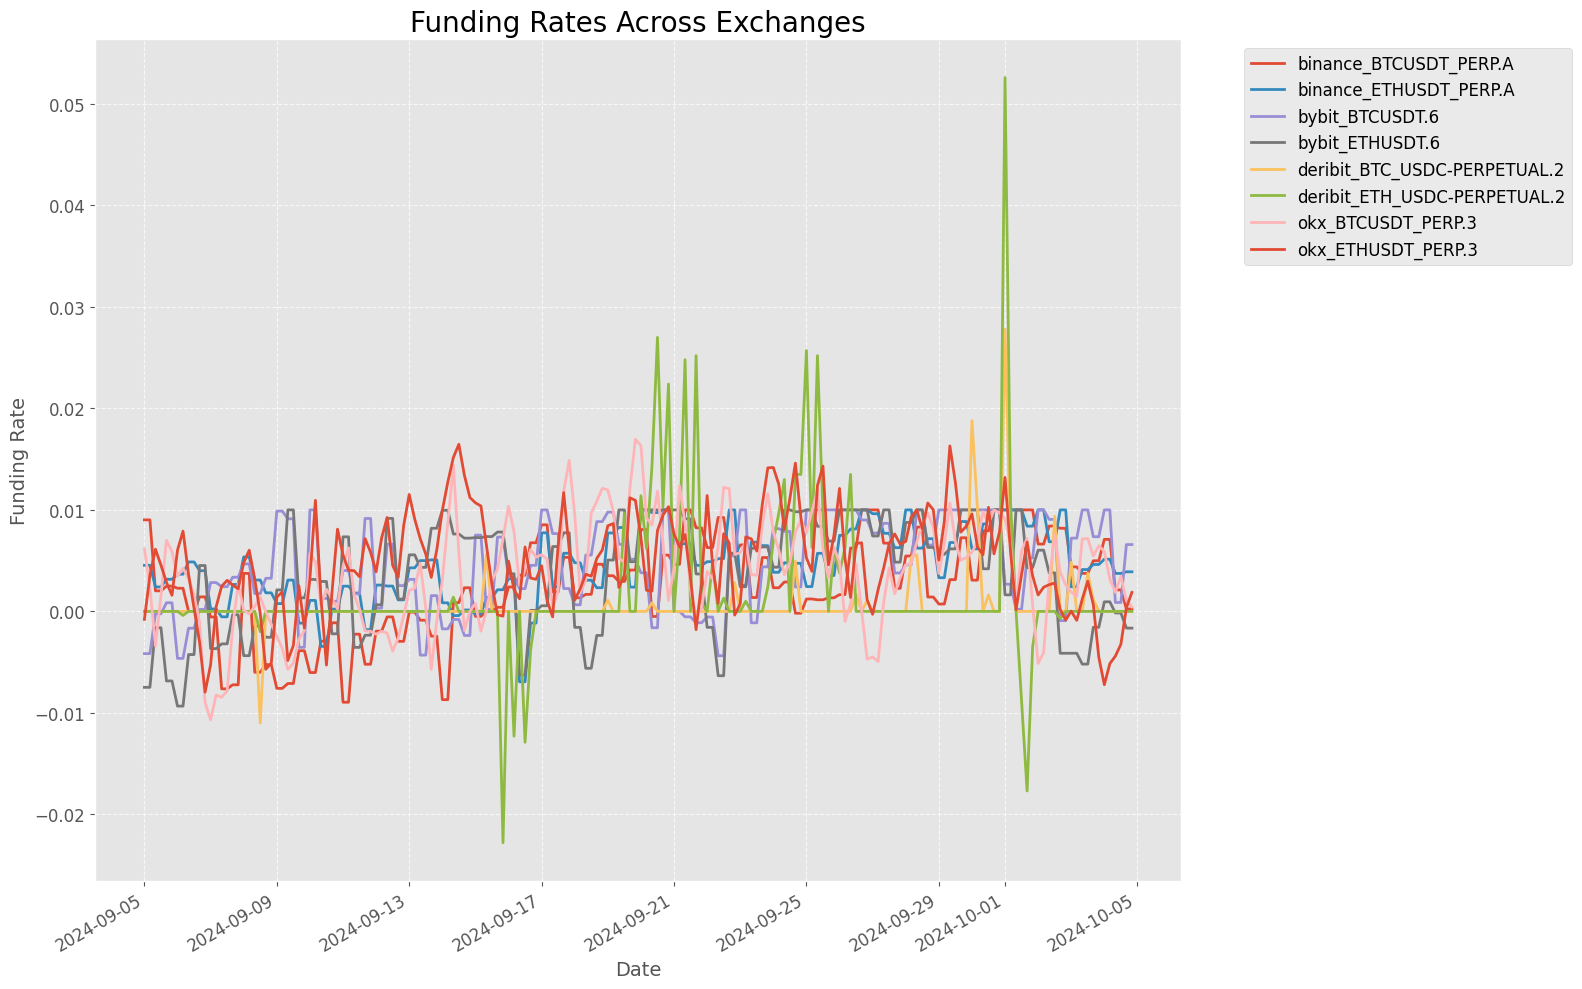

In [41]:
import matplotlib.pyplot as plt

# Use a built-in style
plt.style.use('ggplot')

# Create the figure and axis objects with a specific size
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each column
for column in funding_df.columns:
    ax.plot(funding_df.index, funding_df[column], label=column, linewidth=2)

# Customize the chart
ax.set_title('Funding Rates Across Exchanges', fontsize=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Funding Rate', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Add a legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout to prevent the legend from being cut off
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the figure
# plt.savefig('funding_rates_chart.png', dpi=300, bbox_inches='tight')